# ECG abnormality detector

## Authors
Sini Lähde <br>
Omar Nasri <br>
Juuso Torikka

### Objective

Objective of this notebook is to demonstrate arrhythmia 
detection from ECG signals. <br>
This notebook contains all relevant functions 
and functionalities for this project.

In [123]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import biosppy.signals.ecg as ecg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,

)
from sklearn.svm import SVC

from typing import Any

In [124]:
DATA_DIRECTORY = "data_sources"
NORMAL_DATA = "normal"
ABNORMAL_DATA = "abnormal"

# 1. Pandas DataFrame creation

In [125]:
def get_file_contents(file_path: str, classification: str) -> pd.DataFrame:
    """Process data file contents.

    Reads data from a specific .csv file and extracts the value column.
    The function splits filename to Subject ID part and and event number.
    These values are added to the dataframe along with classification label.

    Parameters
    ----------
    file_path : str
        Full file path to processed file.
    classification : str
        Classification label of the file.

    Returns
    -------
    pd.DataFrame
        Modified Pandas DataFrame

    """

    file_name = os.path.basename(file_path)
    subject_id, event_number = file_name.replace(".csv", "").split("_")[1:]
    subject_id = subject_id.replace("ID", "")

    data = pd.read_csv(file_path)

    data["event_number"] = event_number
    data["subject_id"] = subject_id
    if classification == NORMAL_DATA:
        data["label"] = 0
        return data
    data["label"] = 1
    return data


def get_directory_contents(directory: str, classification: str) -> pd.DataFrame:
    """Process all files in a directory.

    Iterates over all files in given directory. These files are passed to
    get_file_contents() function, which processes each file. Function combines
    all processed files into one Pandas DataFrame.

    Parameters
    ----------
    directory : str
        Root directory of the source data.
    classification : str
        Subdirectory in root, which indicates to correct classification.

    Returns
    -------
    pd.DataFrame
        Concatenated Pandas DataFrame of all files in same directory.

    """
    full_dataset = []
    directory = os.path.join(directory, classification)
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        data = get_file_contents(file_path=file_path, classification=classification)
        data.shape
        full_dataset.append(data)

    return pd.concat(full_dataset, ignore_index=True)


def combine_all_data() -> pd.DataFrame:
    """Combine all data into one DataFrame

    Functions calls processing tasks to get all the data together
    from their respective directories. Combines all these together.

    Returns
    -------
    pd.DataFrame
        Combined Normal and Abnormal data.

    """

    normal_data = get_directory_contents(DATA_DIRECTORY, NORMAL_DATA)
    print("Normal data has been processed\n")
    abnormal_data = get_directory_contents(DATA_DIRECTORY, ABNORMAL_DATA)
    print("Abnormal data has been processed\n")

    df = pd.concat([normal_data, abnormal_data], ignore_index=True)
    return df.sort_values(["subject_id", "event_number", "label"])

In [126]:
df_total_metrics = combine_all_data()

Normal data has been processed

Abnormal data has been processed



In [127]:
display(df_total_metrics.head())

,Lead II,event_number,subject_id,label
0,-0.390,0,100,0
1,-0.395,0,100,0
2,-0.390,0,100,0
3,-0.405,0,100,0
4,-0.405,0,100,0


# 2. Filtering and normalization

In [128]:
def bandpass_filter(data: np.ndarray, Fs: float) -> np.ndarray:
    """Apply a bandpass Butterworth filter.

    Apply fourth-order Butterworth bandpass filter
    to the input data. Passband of the filter is between 0.5 Hz and 40 Hz

    Parameters
    ----------
    data : np.ndarray
        The input signal data as a numpy array.
    Fs : float
        Sampling frequency.

    Returns
    -------
    np.ndarray
        Filtered signal.

    """

    b, a = sp.signal.butter(4, [0.5, 40], btype="bandpass", fs=Fs)
    w, h = sp.signal.freqz(b, a, fs=Fs)
    return sp.signal.filtfilt(b, a, data)

In [129]:
def apply_z_score(data: np.ndarray) -> np.ndarray:
    """Compute z-score for each value.

    Parameters
    ----------
    data : np.ndarray
        Input data.

    Returns
    -------
    np.ndarray
        Computed z-score array.
    """
    return sp.stats.zscore(data)

In [130]:
# Create a dataframe for feature extraction
Fs = 360
df_features = pd.DataFrame(
    columns=[
        "subject_id",
        "event_number",
        "label",
        "qrs_duration",
        "qrs_amplitude",
        "ST_duration",
        "T_duration",
        "T_amplitude",
        "RR_interval",
    ]
)


def calculate_qrs_durations(
    ecg: np.ndarray, rpeaks: np.ndarray, Fs: int
) -> tuple[float, list]:
    """Calculate mean duration of QRS and S wave starting points.

    ECG signal is smoothed with Savitzky-Golay filter.
    Its derivative is used to find zero crossing before and after each R-peak to help determining QRS duration.

    Parameters
    ----------
    ecg : np.ndarray
        ECG signal.
    rpeaks : np.ndarray
        R-Peaks.
    Fs : int
        Frequency

    Returns
    -------
    tuple[float, list]
        Mean duration of QRS complexes in seconds.
        Start positions of the S waves in seconds.

    """
    filtered_qrs_durations = []
    smoothed_ecg = sp.signal.savgol_filter(ecg, window_length=5, polyorder=3)
    derivative = np.gradient(smoothed_ecg)
    s_wave_start_positions = []
    for i in range(len(rpeaks)):
        rpeak = rpeaks[i]
        j = rpeak
        while j > 0:
            if derivative[j] > 0:
                j -= 1
            else:
                break
        k = rpeak
        while k < len(derivative):
            if derivative[k] < 0:
                k += 1
            else:
                break
        filtered_qrs_durations.append((k - j) / Fs)
        s_wave_start_positions.append(k / Fs)
    return np.mean(filtered_qrs_durations), s_wave_start_positions


def calculate_t_wave_features(
    ecg: np.ndarray, rpeaks: np.ndarray, Fs: int
) -> tuple[float, float, list[float]]:
    """Calculate T-wave features.

    Obtain the means of amplitude and duration and
    start positions of T-waves.

    Parameters
    ----------
    ecg : np.ndarray
        ECG signal..
    rpeaks : np.ndarray
        Signal R-peak indices.
    Fs : int
        Sampling frequency.

    Returns
    -------
    tuple[float, float, list[float]]
        Mean amplitude of T-waves.
        Mean duration of T-waves in seconds.
        Start positions of T-waves in seconds.
    """

    t_amplitudes = []
    t_wave_timestamps = []
    delay_start = int(0.05 * Fs)
    delay_end = int(0.4 * Fs)

    for i in range(len(rpeaks)):
        rpeak = rpeaks[i]
        gap_start = rpeak + delay_start
        gap_end = rpeak + delay_end
        gap_values = ecg[gap_start:gap_end]

        if len(gap_values) == 0:
            continue
        else:
            t_amplitude = np.max(gap_values)
            t_amplitudes.append(t_amplitude)

        max_index = np.argmax(gap_values) + gap_start
        t_wave_timestamps.append(max_index)

    t_wave_timestamps = pd.Series(t_wave_timestamps)
    t_wave_timestamps = t_wave_timestamps[:-1]
    smoothed_ecg = sp.signal.savgol_filter(ecg, window_length=5, polyorder=3)
    derivative = np.gradient(smoothed_ecg)
    t_durations = []
    t_wave_start_positions = []

    for i in range(len(t_wave_timestamps)):
        t_wave = t_wave_timestamps[i]
        j = t_wave - int(0.12 * Fs)

        while j < len(derivative):
            if derivative[j] > 0:
                j += 1
            else:
                break

        k = t_wave + int(0.15 * Fs)
        while k < len(derivative):
            if derivative[k] < 0:
                k += 1
            else:
                break

        t_durations.append((k - j) / Fs)
        t_wave_start_positions.append(j / Fs)

    return np.mean(t_amplitudes), np.mean(t_durations), t_wave_start_positions


def calculate_st_duration(
    t_wave_start_positions: np.ndarray, s_wave_start_positions: np.ndarray
) -> float:
    """
    Calculate the mean ST segment duration

    The ST duration is calculated for each pair of T-wave and S-wave start positions,
    with the mean duration across all calculated differences returned.

    Parameters
    ----------
    t_wave_start_positions : np.ndarray
        T-wave start positions in seconds.
    s_wave_start_positions : np.ndarray
        S-wave start positions in seconds.
    Returns
    -------
    float
        Mean ST segment duration as the average difference between T-wave and S-wave
        start positions.
    """
    st_durations = []
    for i in range(len(t_wave_start_positions)):
        st_durations.append(t_wave_start_positions[i] - s_wave_start_positions[i])
    return np.mean(st_durations)


def extractFeatures(df: pd.DataFrame, Fs: int) -> pd.DataFrame:
    """Extract features from ECG signal.

    Extracts RR intervals, features of QRS complex,
    T-wave features, and ST segment duration.

    This function iterates through 10 second segments of an ECG signal
    and applies a bandpass filter and Z-score normalization,
    detects R-peaks, and calculates necessary features.

    Parameters
    ----------
    df : pd.DataFrame
        Signal to be processed.
    Fs : int
        Sampling rate.

    Returns
    -------
    pd.Dataframe
        DataFrame with extracted features for each segment.

    """

    ten_second_sample = Fs * 10
    iterations = int(len(df) / ten_second_sample)

    for i in range(iterations):
        ecg_signal = df["Lead II"].values[
            i * (ten_second_sample) : (i + 1) * (ten_second_sample)
        ]
        ecg_signal_filtered = bandpass_filter(ecg_signal, Fs)
        ecg_signal_filtered = apply_z_score(ecg_signal_filtered)

        rpeaks = ecg.hamilton_segmenter(signal=ecg_signal_filtered, sampling_rate=Fs)[0]

        rr_interval = np.mean(np.diff(rpeaks / Fs))

        qrs_amplitudes = [ecg_signal_filtered[rpeak] for rpeak in rpeaks]
        qrs_amplitude = np.mean(qrs_amplitudes)
        qrs_duration, s_start = calculate_qrs_durations(ecg_signal_filtered, rpeaks, Fs)

        t_duration, t_amplitude, t_start = calculate_t_wave_features(
            ecg_signal_filtered, rpeaks, Fs
        )

        st_duration = calculate_st_duration(t_start, s_start)

        df_features.loc[i] = [
            df["subject_id"][i * (ten_second_sample)],
            df["event_number"][i * (ten_second_sample)],
            df["label"][i * (ten_second_sample)],
            qrs_duration,
            qrs_amplitude,
            st_duration,
            t_duration,
            t_amplitude,
            rr_interval,
        ]
    return df_features

In [131]:
df_features = extractFeatures(df_total_metrics, Fs)

In [132]:
display(df_features.head())

,subject_id,event_number,label,qrs_duration,qrs_amplitude,ST_duration,T_duration,T_amplitude,RR_interval
0,100,0,0,0.025694,7.027026,0.240909,0.213224,0.271970,0.819192
1,100,1,0,0.024573,6.808983,0.226389,0.208369,0.274306,0.806019
2,100,10,0,0.024537,6.935898,0.231061,0.222428,0.271970,0.807828
3,100,100,0,0.025427,6.759421,0.224769,0.178942,0.266898,0.793056
4,100,101,0,0.024306,6.959680,0.228535,0.192532,0.263131,0.800758


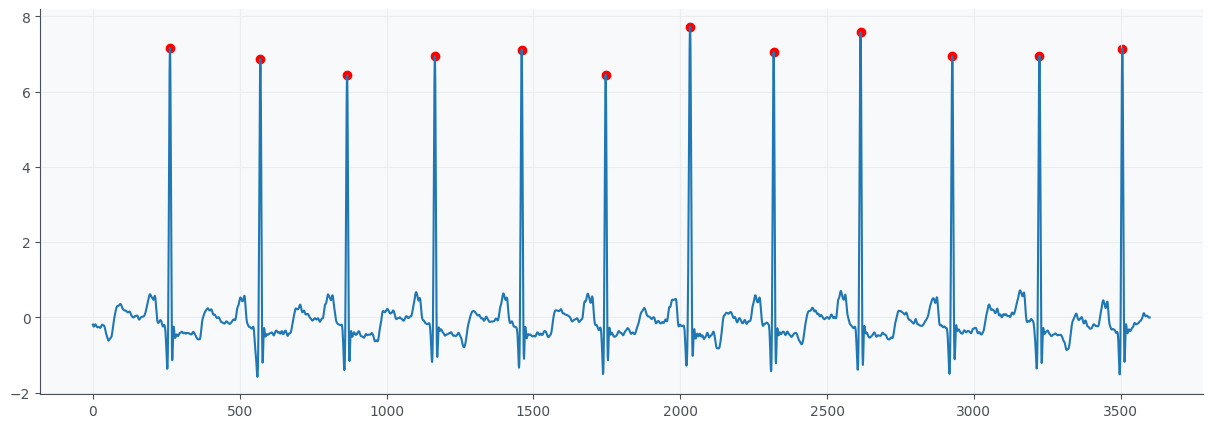

In [133]:
"""Testing the feature calculation.

Creating a test signal, filtering and normalizing it.
Calculate R-peaks and T-peaks.

Plot test signal.
"""

test_ecg = df_total_metrics["Lead II"].values[: 10 * Fs]

test_ecg = bandpass_filter(test_ecg, Fs)

test_ecg = apply_z_score(test_ecg)

rpeaks = ecg.hamilton_segmenter(test_ecg, sampling_rate=Fs)[0]

t_amplitude, t_duration, t = calculate_t_wave_features(test_ecg, rpeaks, Fs)

plt.figure(figsize=(15, 5))
plt.plot(test_ecg)
plt.scatter(rpeaks, test_ecg[rpeaks], c="r")

# 4. Modeling

## Pre-process for models

In [134]:
FEATURES = [
    "qrs_duration",
    "qrs_amplitude",
    "ST_duration",
    "T_duration",
    "T_amplitude",
    "RR_interval",
]
LABEL = "label"

features = df_features[FEATURES].values
labels = df_features[LABEL].values

total_metrics = {
    "SVM-Accuracy": [],
    "SVM-Precision": [],
    "SVM-Recall": [],
    "SVM-F1": [],
    "KNN-Accuracy": [],
    "KNN-Precision": [],
    "KNN-Recall": [],
    "KNN-F1": [],
}

In [135]:
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.3, stratify=labels, random_state=42
)
X_test, X_unseen, y_test, y_unseen = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42
)

In [136]:
"""Initialize dataframe where predictions are added."""

predictions_df = pd.DataFrame(X_unseen, columns=FEATURES)
predictions_df["true_label"] = y_unseen

In [137]:
def _get_metrics(
    actual: np.ndarray, prediction: np.ndarray
) -> tuple[float, float, float, float, np.ndarray]:
    """Get model metrics.

    Parameters
    ----------
    actual: np.ndarray
        Actual labels.
    prediction: np.ndarray
        Predicted labels.

    Returns
    -------
    tuple[float, float, float, float, np.ndarray]
        Metrics: accuracy, precision, recall, f1, confusion matrix

    """

    accuracy = accuracy_score(actual, prediction)
    precision = precision_score(actual, prediction)
    recall = recall_score(actual, prediction)
    f1 = f1_score(actual, prediction)
    conf_matrix = confusion_matrix(actual, prediction)

    return accuracy, precision, recall, f1, conf_matrix

## Support Vector Machine (SVM)

In [138]:
def get_svm_classifier(X_train: np.ndarray, y_train: np.ndarray) -> SVC:
    """Train an SVM classifier.

    Function trains a Support Vector Machine classifier with an RBF kernel and evaluates it.

    Parameters
    ----------
    X_train: np.ndarray
        Train features.
    y_train: np.ndarray
        Train labels.

    Returns
    -------
    SVC
        SVM-model

    """

    svm_classifier = SVC(kernel="rbf", random_state=42, gamma="auto", C=13)
    model = svm_classifier.fit(X_train, y_train)

    predictions = model.predict(X_test)

    accuracy, precision, recall, f1, conf_matrix = _get_metrics(y_test, predictions)

    print(
    f"SVM Metrics of training data:\n\
        Accuracy: {accuracy:.4f}\n\
        Precision: {precision:.4f}\n\
        Recall: {recall:.4f}\n\
        F1 Score: {f1:.4f}\n\nConfusion Matrix:\n{conf_matrix}"
    )

    return model

In [139]:
svm_classifier= get_svm_classifier(X_train, y_train)

SVM Metrics of training data:
        Accuracy: 0.7945
        Precision: 0.7956
        Recall: 0.8096
        F1 Score: 0.8025

Confusion Matrix:
[[625 178]
 [163 693]]


In [140]:
svm_predictions = svm_classifier.predict(X_unseen)
predictions_df["svm_predicted_label"] = svm_predictions

accuracy, precision, recall, f1, conf_matrix_svm = _get_metrics(y_unseen, svm_predictions)
total_metrics.update(
    {
        "SVM-Accuracy": accuracy,
        "SVM-Precision": precision,
        "SVM-Recall": recall,
        "SVM-F1": f1,
    }
)

print(
f"SVM Metrics of test data:\n\
    Accuracy: {accuracy:.4f}\n\
    Precision: {precision:.4f}\n\
    Recall: {recall:.4f}\n\
    F1 Score: {f1:.4f}\n\n\
Confusion Matrix:\n{conf_matrix_svm}"
)

SVM Metrics of test data:
    Accuracy: 0.8090
    Precision: 0.8083
    Recall: 0.8128
    F1 Score: 0.8106

Confusion Matrix:
[[285  69]
 [ 67 291]]


## K-Nearest Neighbor (KNN) Classification

In [141]:
K_VALUES = [1, 3, 5, 7, 9, 11, 13, 15, 17]


def k_nn_classifier(
    X_train: np.ndarray, y_train: np.ndarray, k_values: list[int]
) -> int:
    """Train KNN classifier.

    Trains K_nearest-neighbor classifier with specified K-values.
    Gets metrics for each k-value and returns the best K which can be used to train a new model.

    Parameters
    ----------
    X_train: np.ndarray
        Train features.
    y_train: np.ndarray
        Train labels.
    k_values: list[int]
        List of specified K-values to iterate.

    Returns
    -------
    int
        Best k-value.
    pd.Dataframe
        DataFrame with metrics for each k-value.
    """
    metrics = {
        "K-value": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
    }

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)

        accuracy, precision, recall, f1, _ = _get_metrics(y_test, y_pred)

        metrics["K-value"].append(k)
        metrics["Accuracy"].append(accuracy)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1"].append(f1)

    metrics_df = pd.DataFrame(metrics)
    best_k = metrics_df.loc[metrics_df["Recall"].idxmax()]
    best_k = int(best_k["K-value"])

    print(f"\nBest K-value based on recall: {best_k}")
    return best_k, metrics_df

best_k, metrics_df = k_nn_classifier(X_train, y_train, K_VALUES)


Best K-value based on recall: 1


In [142]:
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)
knn_predictions = knn_final.predict(X_unseen)

In [143]:
accuracy, precision, recall, f1, conf_matrix_knn = _get_metrics(y_unseen, knn_predictions)
total_metrics.update(
    {
        "KNN-Accuracy": accuracy,
        "KNN-Precision": precision,
        "KNN-Recall": recall,
        "KNN-F1": f1,
    }
)

print(
f"KNN Metrics of test data:\n\
    Accuracy: {accuracy:.4f}\n\
    Precision: {precision:.4f}\n\
    Recall: {recall:.4f}\n\
    F1 Score: {f1:.4f}\n\n\
Confusion Matrix:\n{conf_matrix_knn}"
)

KNN Metrics of test data:
    Accuracy: 0.8652
    Precision: 0.8830
    Recall: 0.8436
    F1 Score: 0.8629

Confusion Matrix:
[[314  40]
 [ 56 302]]


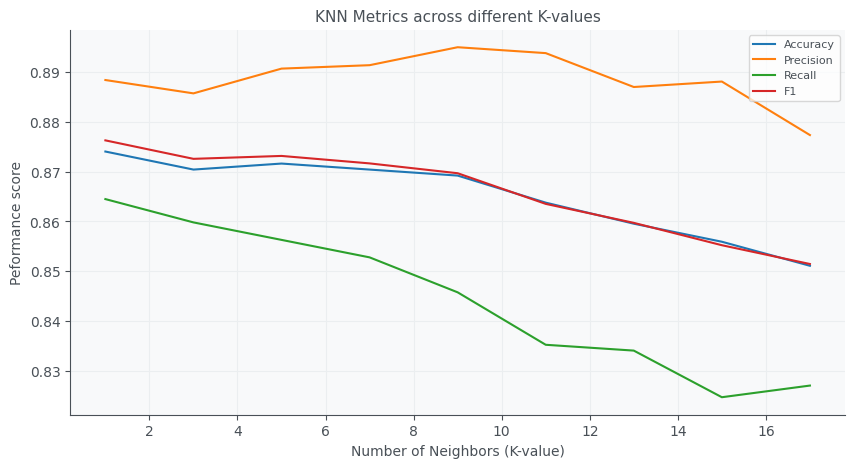

In [144]:
#Plot KNN metrics
fig = plt.figure(figsize=(10, 5))
plt.plot(metrics_df["K-value"], metrics_df["Accuracy"], label="Accuracy")
plt.plot(metrics_df["K-value"], metrics_df["Precision"], label="Precision")
plt.plot(metrics_df["K-value"], metrics_df["Recall"], label="Recall")
plt.plot(metrics_df["K-value"], metrics_df["F1"], label="F1")
plt.title("KNN Metrics across different K-values")
plt.xlabel("Number of Neighbors (K-value)")
plt.ylabel("Peformance score")
plt.legend()

The graph indicates that a k-value 1 clearly provides the best performance. It tells that the model, in its predictions, considers only the nearest neighbor. While this approach may be more sensitive to errors, it is excellent at identifying positive cases (=abnormal ECG).

The "Precision" curve appears relatively flat across different k-values compared to others. This implies that the model's predictions are quite stable and not particularly sensitive to the number of neighbors considered in the predictions. Because "Precision" measures how accurately the model identifies positive cases, it maintains stable positive predictions and avoids making too many false positive predictions.
_____________________________________

In [145]:
predictions_df["k_nn_predicted_label"] = knn_predictions
predictions_df

,qrs_duration,qrs_amplitude,ST_duration,T_duration,T_amplitude,RR_interval,true_label,svm_predicted_label,k_nn_predicted_label
0,0.042037,4.488716,0.228373,1.466010,0.150198,0.674206,1,1,1
1,0.028993,3.886878,0.120926,1.404889,0.255185,0.630556,1,1,1
2,0.038095,4.465087,0.219444,0.712549,0.260043,0.690385,0,0,0
3,0.025000,6.574189,0.176282,0.572939,0.268590,0.721154,1,1,1
4,0.021759,5.784952,0.061869,0.364909,0.270202,0.827525,1,1,1
...,...,...,...,...,...,...,...,...,...
707,0.055324,2.432740,0.300758,1.533862,0.161869,0.829798,1,0,0
708,0.031389,7.193404,0.198457,0.871768,0.241667,0.924383,1,0,1
709,0.045455,5.169972,0.272778,0.425073,0.190833,0.846667,0,0,1
710,0.053395,5.124924,0.131597,0.802216,0.263542,1.022917,0,0,0


In [146]:
total_metrics

{'SVM-Accuracy': 0.8089887640449438,
 'SVM-Precision': 0.8083333333333333,
 'SVM-Recall': 0.8128491620111732,
 'SVM-F1': 0.8105849582172702,
 'KNN-Accuracy': 0.8651685393258427,
 'KNN-Precision': 0.8830409356725146,
 'KNN-Recall': 0.8435754189944135,
 'KNN-F1': 0.8628571428571429}

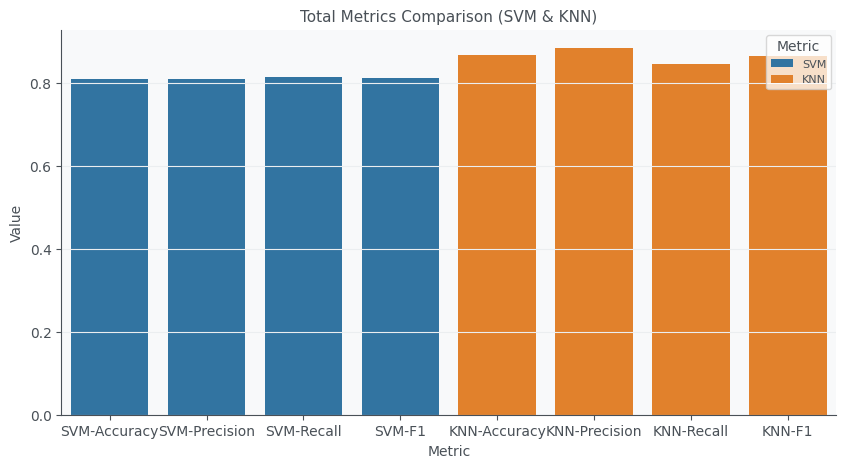

In [160]:
df_total_metrics = pd.DataFrame(list(total_metrics.items()), columns=['Metric', 'Value'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Metric', y='Value', data=df_total_metrics, hue=df_total_metrics['Metric'].str.split('-').str[0])
plt.title('Total Metrics Comparison (SVM & KNN)')
plt.ylabel('Value')
plt.show()

In SVM model, accuracy indicates that it correctly predicts about 80.9% of all cases. Precision, recall, and F1 score are all at a similar level (~ 81%), suggesting that the model is not particularly strong in predicting positive or negative cases. 

In KNN model, the high accuracy indicates that it correctly predicts about 86.5% of all cases. Precision around 88.3% indicates that a large portion of cases predicted as positive were positive. Recall around 84.4% suggests that it detects true positive cases. 

"Recall" is an important and critical metric in ECG identification. Recall identifies all true positives relative to all true positives. When identifying an ECG, we want to avoid false negative results, i.e. that the patient actually has an abnormal result, but the model gives a normal "diagnosis". The KNN model seems to perform better in these metrics compared to the SVM model.

___________________________________________

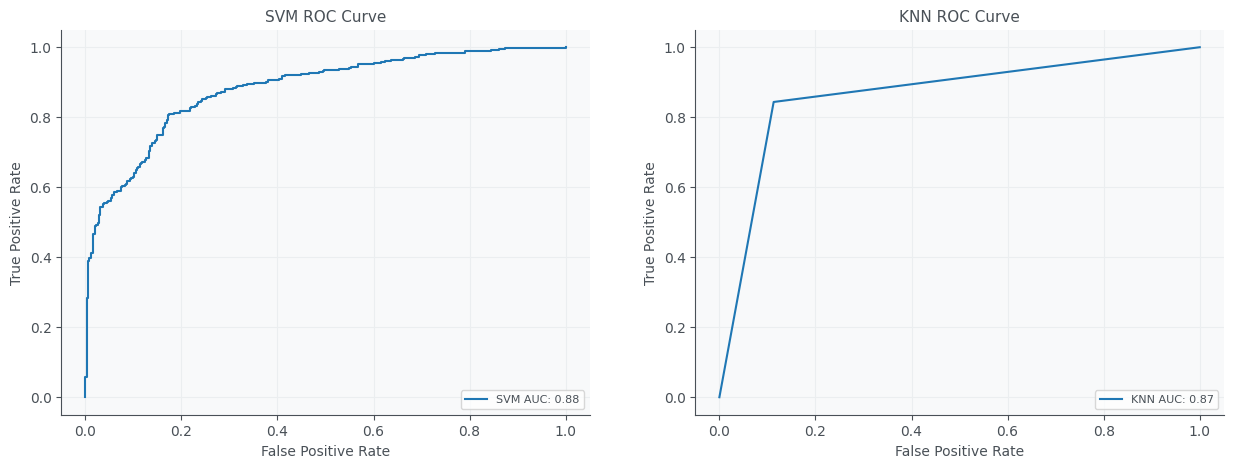

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#Aurocs for the models 
#SVM
svm_probs = svm_classifier.decision_function(X_unseen)
svm_fpr, svm_tpr, _ = roc_curve(y_unseen, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)

ax[0].plot(svm_fpr, svm_tpr, label=f"SVM AUC: {svm_auc:.2f}")
ax[0].set_title("SVM ROC Curve")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend(loc="lower right")

#KNN
knn_probs = knn_final.predict_proba(X_unseen)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_unseen, knn_probs)
knn_auc = auc(knn_fpr, knn_tpr)

ax[1].plot(knn_fpr, knn_tpr, label=f"KNN AUC: {knn_auc:.2f}")
ax[1].set_title("KNN ROC Curve")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend(loc="lower right")


AUC (Area Under the Curve) describes the area under the ROC (Receiver Operating Characteristic) curve. That's how well the model separates positive and negative cases. The larger the area under, the better the performance.

SVM-based models tend to give more curved ROC curves. It may be because it is more sensitive to changes in different threshold values. KNN-based models often give straighter curves. KNN-based models often take the value of the nearest neighbor, so the result is smoother.

The AUC values of both are very similar (SVM 1% better), so it is impossible to interpret which one is better just by using this graph alone.
_________________________________

Text(0.5, 1.0, 'KNN Confusion Matrix')

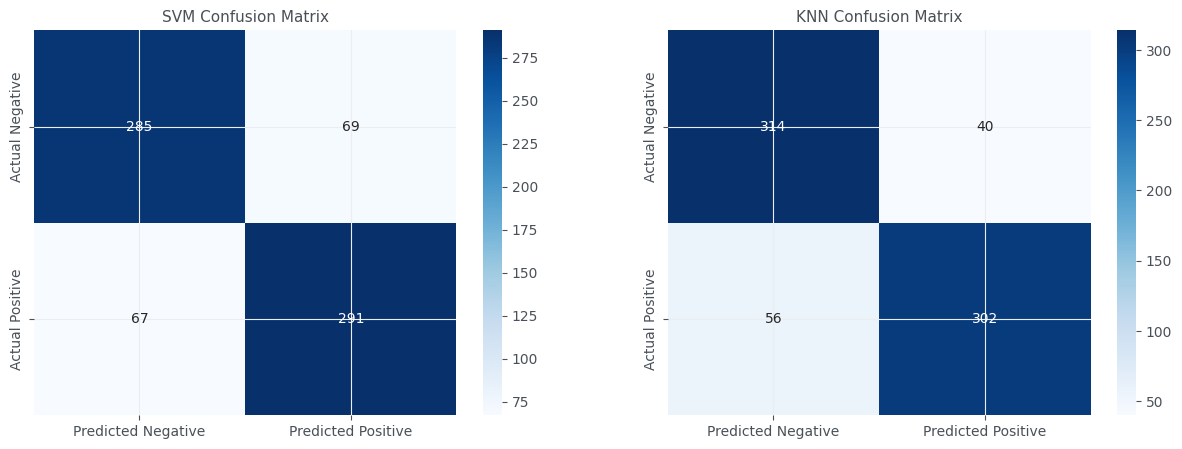

In [148]:
#Confusion matrices for the models
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

#SVM
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", ax=ax[0],
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
ax[0].set_title("SVM Confusion Matrix")

#KNN
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", ax=ax[1],
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
ax[1].set_title("KNN Confusion Matrix")


 The confusion matrices shows
- Actual and Predicted Negative (top left)
    - correctly predicted the <span style="color:green">negative</span> cases (=normal ECG)
- Actual and Predicted Positive (bottom right) 
    - correctly predicted the <span style="color:red">positive</span> cases (=abnormal ECG)
- Actual Negative but Predicted Positive (top right) 
    - actual <span style="color:green">negative</span>, but were predicted <span style="color:red">positive</span> (=normal ECG, but diagnosed to abnormal)
- Actual Positive but Predicted Negative (bottom left)
    - actual <span style="color:red">positive</span>, but were predicted <span style="color:green">negative</span> (=abnormal ECG, but diagnosed to normal)


Based on the colors of the matrices, it is easy to see that more correct results (dark color) have been obtained than incorrect ones (light). By comparing SVM and KNN matrices, you can quickly interpret that the results of KNN are more correct in relation to the results of SVM.

The left bottom (actual positive but predicted negative) is the most critical in diagnosing an abnormal ECG. In the KNN model, its ratio (recall 84%) is better than in the SVM model (recall 81%).

________________________________________________________________